In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
 
''' Choose columns to incorporate '''
#hourly_aggregated.to_csv("../data/numeric_aggregated_minute.csv",sep = ";",decimal = ".")
hourly_aggregated = pd.read_csv("../data/aggregated_numeric_data.csv",sep = ";",decimal = ".")

[Timestamp('2022-04-25 00:00:00'), Timestamp('2022-05-04 00:00:00'), Timestamp('2022-05-24 00:00:00'), Timestamp('2022-05-29 00:00:00'), Timestamp('2022-06-14 00:00:00')]
(71150, 302)
   local_time  product_code [None]  production_order_code [None]  \
0  local_time  product_code [None]  production_order_code [None]   

   Abzug Flachlegung [mm]  Abzug Zentralführung [mm]  \
0  Abzug Flachlegung [mm]  Abzug Zentralführung [mm]   

   Anlage Stillstandsgrund [-]  Auftrag Länge (Soll) [m]  Außenluft 1 [%]  \
0  Anlage Stillstandsgrund [-]  Auftrag Länge (Soll) [m]  Außenluft 1 [%]   

   Bahngeschwindigkeit [m/min]  Blaskopf Zone 1 Temperatur (Soll) [°C]  \
0  Bahngeschwindigkeit [m/min]  Blaskopf Zone 1 Temperatur (Soll) [°C]   

   Blaskopf Zone 1 Temperatur [°C]  Blaskopf Zone 10 Temperatur (Soll) [°C]  \
0  Blaskopf Zone 1 Temperatur [°C]  Blaskopf Zone 10 Temperatur (Soll) [°C]   

   Blaskopf Zone 10 Temperatur [°C]  Blaskopf Zone 2 Temperatur (Soll) [°C]  \
0  Blaskopf Zone 10 Temp

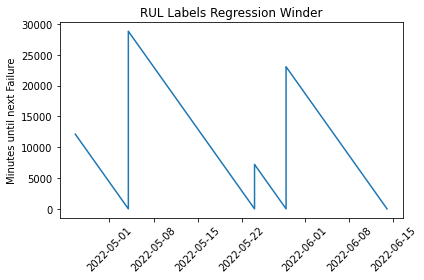

In [3]:
'''Add the RUL days'''
# Load Failure timestamps
#failure_timestamps =  pd.read_csv("../data/timestamps_three_sigma.csv")
#failure_timestamps = failure_timestamps["local_time"]
failure_timestamps = ["2022-04-25","2022-05-04","2022-05-24","2022-05-29","2022-06-14"]
# 1.) Convert zero_days to datetime objects
failure_timestamps = [pd.Timestamp(day) for day in failure_timestamps]
print(failure_timestamps)

nr_of_failures = len(failure_timestamps)


hourly_aggregated["Date"] = pd.to_datetime(hourly_aggregated["local_time"]).dt.floor("min")

# Create copy of original, aggregated data
merged_data = hourly_aggregated


dfs = []

# 2.) Calculate remaining days-hours-minutes for each row
# TODO
# uncomment depending on wished function
all_dates = pd.DataFrame()
dfs = []
for index,end_day in enumerate(failure_timestamps[:nr_of_failures-1]):
    #day_list = pd.date_range(start=zero_days[index], end=zero_days[index+1],inclusive="right").to_list()
    #hour_list = pd.date_range(start=failure_timestamps[index], end=failure_timestamps[index+1],inclusive="right",freq='H')
    minute_list = pd.date_range(start=failure_timestamps[index], end=failure_timestamps[index+1],inclusive="right",freq='min')

    #remaining_days = [(zero_days[index+1] - day).hour for day in day_list]
    #remaining_hours = [(failure_timestamps[index+1] - hour).total_seconds() // 3600 for hour in hour_list]
    remaining_minutes = [(failure_timestamps[index+1] - minute).total_seconds() // 60 for minute in minute_list]

    # Replace with respective list and RUL corresponding to liens before
    df = pd.DataFrame({'Date': minute_list, 'RUL': remaining_minutes})

    dfs.append(df)

all_dates = pd.concat(dfs)

all_dates["Date"] = pd.to_datetime(all_dates["Date"]).dt.floor("min")
all_dates["Date"].to_list()

# 3.) merge RUL table with original table, the transformation before must be done 
# to convert the Date row to the correct format
merged_data = pd.merge(merged_data,all_dates,on="Date")


# 4.) Create dataset without date values
clean_merged = merged_data.drop("local_time",axis=1)
#clean_merged = clean_merged.drop("Date",axis=1)
#clean_merged["Date"] = clean_merged["Date"].astype("str")
clean_merged.dtypes
merged_data["RUL"].to_list()


## 5.) Final renaming necessarry for algorithms
clean_merged.rename(columns=lambda x: x.replace('[', '').replace(']', ''), inplace=True)

# Plot rul

plt.plot(merged_data["Date"],merged_data["RUL"])

plt.title("RUL Labels Regression Winder")
plt.ylabel("Minutes until next Failure")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("rul_winder_regression.png")
plt.show
print(merged_data.shape)
print(merged_data.columns.to_frame().T)
print(clean_merged.columns)

(71150, 22)
(71150, 21)


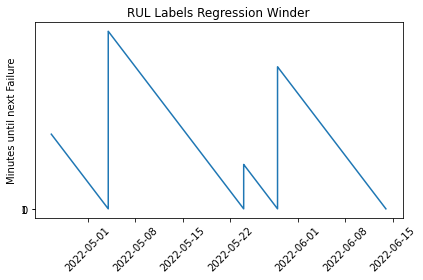

In [4]:
# Do various other transformations of the trainings data, f.I. choose only specific columns

merged_data_final = merged_data

columns_granger = pd.read_csv("cross_correlation_df.csv")
columns_granger = columns_granger["index"].to_list()
columns_granger.remove("RUL")
columns = []
#columns = [x for x in merged_data.columns if "kW" in x]
#columns = [x for x in merged_data.columns if "Extruder" in x]
#columns = columns + ["Bahngeschwindigkeit [m/min]","RUL","Date","local_time"]
'''columns = ["Druckluftverbrauch [Nm3/h]","Extruder B Motorstrom [A]","Extruder B Massedruck [bar]","Extruder B Massetemperatur [°C]",
                       "Extruder A Motorstrom [A]","Extruder A Massedruck [bar]","Extruder A Massetemperatur [°C]",
                       "Extruder C Motorstrom [A]","Extruder C Massedruck [bar]","Extruder C Massetemperatur [°C]","Leistung [kW]","Mittelwert Foliendicke [µm]","Prozessabwärme [kW]",
                       "Spezifische Energie gesamt [kWh/kg]","Wobble Median [mm]","Wärmetauscher Kühlleistung [kW]","Durchsatz [kg/h]","product_code [None]","Date","RUL"]
'''
#merged_data_final = merged_data[columns]
merged_data_final = merged_data[columns_granger[0:20] + ["RUL","Date"]]

print(merged_data_final.shape)



'''Only look at last 5hrs before spike'''
#merged_data_final = merged_data_final[merged_data_final["RUL"] <= 900]
plt.plot(merged_data["Date"],merged_data["RUL"])
plt.title("RUL Labels Regression Winder")
plt.ylabel("Minutes until next Failure")
plt.xticks(rotation= 45)
plt.yticks([0,1])
plt.tight_layout()
#plt.savefig("rul_regression.png")
plt.show

''' Create Validation set consisting of last cycle '''
last_cycle = merged_data_final[merged_data_final["Date"] > '2022-05-29 14:00:00']
last_cycle

''' Create Train set consisting of all data before '''
first_cycles = merged_data_final[merged_data_final["Date"] <= '2022-05-29 14:00:00']
first_cycles.shape

''' Clean those datasets for training '''
#first_cycles = first_cycles.drop("local_time",axis=1)
first_cycles = first_cycles.drop("Date",axis=1)
first_cycles.rename(columns=lambda x: x.replace('[', '').replace(']', ''), inplace=True)

#last_cycle = last_cycle.drop("local_time",axis=1)
last_cycle = last_cycle.drop("Date",axis=1)
last_cycle.rename(columns=lambda x: x.replace('[', '').replace(']', ''), inplace=True)

first_cycles.shape

#merged_data_final = merged_data_final.drop("local_time",axis=1)
merged_data_final = merged_data_final.drop("Date",axis=1)
merged_data_final.rename(columns=lambda x: x.replace('[', '').replace(']', ''), inplace=True)
print(merged_data_final.shape)

In [5]:
import tensorflow as tf
tf.random.set_seed(0)

# 1.) Split train and test set

y = merged_data_final["RUL"]
X = merged_data_final.drop("RUL",axis=1)


print(X.shape)


# split up data into training and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# split up training set into training and validation part
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.5, random_state=0)

print(type(X_train))
print(X_train.shape)
print(y_train.shape)

(71150, 20)
<class 'pandas.core.frame.DataFrame'>
(28460, 20)
(28460,)


In [13]:
''' RUL prediction XG Boost'''
''' 1.) Split in train and testdata'''
y = first_cycles["RUL"]
X = first_cycles.drop("RUL",axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=22)

parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, 0.04],
              'max_depth': [6],
              'colsample_bytree': [0.5,0.6],
              'n_estimators': [450,500],
              'reg_lambda': [0]
             }

grid_search = GridSearchCV(
                        xgboost.XGBRegressor(),
                        parameters,
                        cv = 3,
                        refit=True, 
                        verbose=False)

%time grid_search.fit(X_train, y_train, eval_metric=["rmse"], eval_set=[(X_train, y_train), (X_valid, y_valid)])


model = grid_search.best_estimator_
print(model)

[0]	validation_0-rmse:12972.85477	validation_1-rmse:12993.61542
[1]	validation_0-rmse:12370.22059	validation_1-rmse:12391.45342
[2]	validation_0-rmse:11812.28426	validation_1-rmse:11835.18549
[3]	validation_0-rmse:11283.66869	validation_1-rmse:11309.18879
[4]	validation_0-rmse:10746.72713	validation_1-rmse:10772.61469


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:10228.33208	validation_1-rmse:10254.04267
[6]	validation_0-rmse:9736.31056	validation_1-rmse:9761.47898
[7]	validation_0-rmse:9283.72164	validation_1-rmse:9308.22421
[8]	validation_0-rmse:8836.87655	validation_1-rmse:8861.07435
[9]	validation_0-rmse:8416.70177	validation_1-rmse:8440.99618
[10]	validation_0-rmse:8017.87817	validation_1-rmse:8041.01362
[11]	validation_0-rmse:7660.19795	validation_1-rmse:7682.44914
[12]	validation_0-rmse:7299.84293	validation_1-rmse:7321.15342
[13]	validation_0-rmse:6963.87137	validation_1-rmse:6983.86000
[14]	validation_0-rmse:6642.92832	validation_1-rmse:6661.72815
[15]	validation_0-rmse:6372.78590	validation_1-rmse:6390.29463
[16]	validation_0-rmse:6092.64338	validation_1-rmse:6107.95827
[17]	validation_0-rmse:5815.68897	validation_1-rmse:5829.30725
[18]	validation_0-rmse:5554.37353	validation_1-rmse:5566.39151
[19]	validation_0-rmse:5307.26328	validation_1-rmse:5317.64691
[20]	validation_0-rmse:5092.61887	validation_1-rmse:5102.0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9278.48731	validation_1-rmse:9305.11455
[8]	validation_0-rmse:8832.53261	validation_1-rmse:8858.34079
[9]	validation_0-rmse:8412.32542	validation_1-rmse:8437.92267
[10]	validation_0-rmse:8012.97417	validation_1-rmse:8037.23843
[11]	validation_0-rmse:7655.99534	validation_1-rmse:7679.03271
[12]	validation_0-rmse:7295.44518	validation_1-rmse:7318.00536
[13]	validation_0-rmse:6957.57964	validation_1-rmse:6979.14108
[14]	validation_0-rmse:6635.55839	validation_1-rmse:6655.96168
[15]	validation_0-rmse:6364.94595	validation_1-rmse:6383.62667
[16]	validation_0-rmse:6085.20466	validation_1-rmse:6102.71102
[17]	validation_0-rmse:5808.68353	validation_1-rmse:5825.41091
[18]	validation_0-rmse:5548.08566	validation_1-rmse:5563.49875
[19]	validation_0-rmse:5301.41969	validation_1-rmse:5315.89618
[20]	validation_0-rmse:5087.17539	validation_1-rmse:5100.56360
[21]	validation_0-rmse:4864.45285	validation_1-rmse:4876.40902
[22]	validation_0-rmse:4660.00028	validation_1-rmse:4671.3

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9268.79284	validation_1-rmse:9293.23519
[8]	validation_0-rmse:8822.34899	validation_1-rmse:8846.04616
[9]	validation_0-rmse:8401.54344	validation_1-rmse:8424.72950
[10]	validation_0-rmse:8003.09412	validation_1-rmse:8024.90960
[11]	validation_0-rmse:7644.72075	validation_1-rmse:7665.56890
[12]	validation_0-rmse:7283.44733	validation_1-rmse:7303.28789
[13]	validation_0-rmse:6946.73809	validation_1-rmse:6965.75413
[14]	validation_0-rmse:6624.77415	validation_1-rmse:6642.51694
[15]	validation_0-rmse:6353.74342	validation_1-rmse:6369.57467
[16]	validation_0-rmse:6073.69289	validation_1-rmse:6088.01000
[17]	validation_0-rmse:5796.47491	validation_1-rmse:5808.99513
[18]	validation_0-rmse:5534.94081	validation_1-rmse:5545.82743
[19]	validation_0-rmse:5287.25679	validation_1-rmse:5296.50013
[20]	validation_0-rmse:5071.42944	validation_1-rmse:5080.83472
[21]	validation_0-rmse:4848.33568	validation_1-rmse:4855.51475
[22]	validation_0-rmse:4644.54318	validation_1-rmse:4650.5

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9283.72164	validation_1-rmse:9308.22421
[8]	validation_0-rmse:8836.87655	validation_1-rmse:8861.07435
[9]	validation_0-rmse:8416.70177	validation_1-rmse:8440.99618
[10]	validation_0-rmse:8017.87817	validation_1-rmse:8041.01362
[11]	validation_0-rmse:7660.19795	validation_1-rmse:7682.44914
[12]	validation_0-rmse:7299.84293	validation_1-rmse:7321.15342
[13]	validation_0-rmse:6963.87137	validation_1-rmse:6983.86000
[14]	validation_0-rmse:6642.92832	validation_1-rmse:6661.72815
[15]	validation_0-rmse:6372.78590	validation_1-rmse:6390.29463
[16]	validation_0-rmse:6092.64338	validation_1-rmse:6107.95827
[17]	validation_0-rmse:5815.68897	validation_1-rmse:5829.30725
[18]	validation_0-rmse:5554.37353	validation_1-rmse:5566.39151
[19]	validation_0-rmse:5307.26328	validation_1-rmse:5317.64691
[20]	validation_0-rmse:5092.61887	validation_1-rmse:5102.07042
[21]	validation_0-rmse:4869.36597	validation_1-rmse:4876.67020
[22]	validation_0-rmse:4664.76600	validation_1-rmse:4670.4

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9278.48731	validation_1-rmse:9305.11455
[8]	validation_0-rmse:8832.53261	validation_1-rmse:8858.34079
[9]	validation_0-rmse:8412.32542	validation_1-rmse:8437.92267
[10]	validation_0-rmse:8012.97417	validation_1-rmse:8037.23843
[11]	validation_0-rmse:7655.99534	validation_1-rmse:7679.03271
[12]	validation_0-rmse:7295.44518	validation_1-rmse:7318.00536
[13]	validation_0-rmse:6957.57964	validation_1-rmse:6979.14108
[14]	validation_0-rmse:6635.55839	validation_1-rmse:6655.96168
[15]	validation_0-rmse:6364.94595	validation_1-rmse:6383.62667
[16]	validation_0-rmse:6085.20466	validation_1-rmse:6102.71102
[17]	validation_0-rmse:5808.68353	validation_1-rmse:5825.41091
[18]	validation_0-rmse:5548.08566	validation_1-rmse:5563.49875
[19]	validation_0-rmse:5301.41969	validation_1-rmse:5315.89618
[20]	validation_0-rmse:5087.17539	validation_1-rmse:5100.56360
[21]	validation_0-rmse:4864.45285	validation_1-rmse:4876.40902
[22]	validation_0-rmse:4660.00028	validation_1-rmse:4671.3

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9268.79284	validation_1-rmse:9293.23519
[8]	validation_0-rmse:8822.34899	validation_1-rmse:8846.04616
[9]	validation_0-rmse:8401.54344	validation_1-rmse:8424.72950
[10]	validation_0-rmse:8003.09412	validation_1-rmse:8024.90960
[11]	validation_0-rmse:7644.72075	validation_1-rmse:7665.56890
[12]	validation_0-rmse:7283.44733	validation_1-rmse:7303.28789
[13]	validation_0-rmse:6946.73809	validation_1-rmse:6965.75413
[14]	validation_0-rmse:6624.77415	validation_1-rmse:6642.51694
[15]	validation_0-rmse:6353.74342	validation_1-rmse:6369.57467
[16]	validation_0-rmse:6073.69289	validation_1-rmse:6088.01000
[17]	validation_0-rmse:5796.47491	validation_1-rmse:5808.99513
[18]	validation_0-rmse:5534.94081	validation_1-rmse:5545.82743
[19]	validation_0-rmse:5287.25679	validation_1-rmse:5296.50013
[20]	validation_0-rmse:5071.42944	validation_1-rmse:5080.83472
[21]	validation_0-rmse:4848.33568	validation_1-rmse:4855.51475
[22]	validation_0-rmse:4644.54318	validation_1-rmse:4650.5

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:10031.95101	validation_1-rmse:10056.56782
[8]	validation_0-rmse:9643.53434	validation_1-rmse:9667.84352
[9]	validation_0-rmse:9274.10450	validation_1-rmse:9298.58832
[10]	validation_0-rmse:8919.82116	validation_1-rmse:8943.34591
[11]	validation_0-rmse:8597.68982	validation_1-rmse:8620.61393
[12]	validation_0-rmse:8270.34530	validation_1-rmse:8292.67238
[13]	validation_0-rmse:7960.61729	validation_1-rmse:7982.16355
[14]	validation_0-rmse:7662.36688	validation_1-rmse:7683.37256
[15]	validation_0-rmse:7406.81094	validation_1-rmse:7426.75665
[16]	validation_0-rmse:7139.73584	validation_1-rmse:7158.13776
[17]	validation_0-rmse:6873.60159	validation_1-rmse:6890.89414
[18]	validation_0-rmse:6619.21521	validation_1-rmse:6635.52830
[19]	validation_0-rmse:6375.42517	validation_1-rmse:6390.49135
[20]	validation_0-rmse:6159.88150	validation_1-rmse:6174.16410
[21]	validation_0-rmse:5934.74681	validation_1-rmse:5947.60243
[22]	validation_0-rmse:5724.97307	validation_1-rmse:5737

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:10027.60497	validation_1-rmse:10054.40661
[8]	validation_0-rmse:9639.25249	validation_1-rmse:9665.75463
[9]	validation_0-rmse:9269.61939	validation_1-rmse:9296.07987
[10]	validation_0-rmse:8915.36030	validation_1-rmse:8940.86355
[11]	validation_0-rmse:8592.90283	validation_1-rmse:8617.86440
[12]	validation_0-rmse:8265.42543	validation_1-rmse:8290.32092
[13]	validation_0-rmse:7956.33984	validation_1-rmse:7980.85799
[14]	validation_0-rmse:7656.95300	validation_1-rmse:7680.45210
[15]	validation_0-rmse:7401.27167	validation_1-rmse:7423.65732
[16]	validation_0-rmse:7131.03353	validation_1-rmse:7153.45068
[17]	validation_0-rmse:6864.90277	validation_1-rmse:6886.43599
[18]	validation_0-rmse:6610.60091	validation_1-rmse:6631.37074
[19]	validation_0-rmse:6366.86130	validation_1-rmse:6386.52321
[20]	validation_0-rmse:6150.58015	validation_1-rmse:6169.87491
[21]	validation_0-rmse:5925.58641	validation_1-rmse:5943.68856
[22]	validation_0-rmse:5715.93573	validation_1-rmse:5733

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:10413.86937	validation_1-rmse:10438.54756
[7]	validation_0-rmse:10019.07731	validation_1-rmse:10043.09928
[8]	validation_0-rmse:9631.01372	validation_1-rmse:9654.73574
[9]	validation_0-rmse:9260.87356	validation_1-rmse:9284.08926
[10]	validation_0-rmse:8906.46080	validation_1-rmse:8928.68745
[11]	validation_0-rmse:8583.58128	validation_1-rmse:8605.23017
[12]	validation_0-rmse:8255.55620	validation_1-rmse:8276.48730
[13]	validation_0-rmse:7946.06682	validation_1-rmse:7966.46087
[14]	validation_0-rmse:7646.65393	validation_1-rmse:7666.31566
[15]	validation_0-rmse:7390.19343	validation_1-rmse:7408.49868
[16]	validation_0-rmse:7122.55798	validation_1-rmse:7139.94393
[17]	validation_0-rmse:6856.19771	validation_1-rmse:6872.62216
[18]	validation_0-rmse:6601.52427	validation_1-rmse:6616.98723
[19]	validation_0-rmse:6357.42649	validation_1-rmse:6371.92894
[20]	validation_0-rmse:6144.16986	validation_1-rmse:6157.34155
[21]	validation_0-rmse:5919.14053	validation_1-rmse:593

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:10031.95101	validation_1-rmse:10056.56782
[8]	validation_0-rmse:9643.53434	validation_1-rmse:9667.84352
[9]	validation_0-rmse:9274.10450	validation_1-rmse:9298.58832
[10]	validation_0-rmse:8919.82116	validation_1-rmse:8943.34591
[11]	validation_0-rmse:8597.68982	validation_1-rmse:8620.61393
[12]	validation_0-rmse:8270.34530	validation_1-rmse:8292.67238
[13]	validation_0-rmse:7960.61729	validation_1-rmse:7982.16355
[14]	validation_0-rmse:7662.36688	validation_1-rmse:7683.37256
[15]	validation_0-rmse:7406.81094	validation_1-rmse:7426.75665
[16]	validation_0-rmse:7139.73584	validation_1-rmse:7158.13776
[17]	validation_0-rmse:6873.60159	validation_1-rmse:6890.89414
[18]	validation_0-rmse:6619.21521	validation_1-rmse:6635.52830
[19]	validation_0-rmse:6375.42517	validation_1-rmse:6390.49135
[20]	validation_0-rmse:6159.88150	validation_1-rmse:6174.16410
[21]	validation_0-rmse:5934.74681	validation_1-rmse:5947.60243
[22]	validation_0-rmse:5724.97307	validation_1-rmse:5737

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:10417.34422	validation_1-rmse:10444.64087
[7]	validation_0-rmse:10027.60497	validation_1-rmse:10054.40661
[8]	validation_0-rmse:9639.25249	validation_1-rmse:9665.75463
[9]	validation_0-rmse:9269.61939	validation_1-rmse:9296.07987
[10]	validation_0-rmse:8915.36030	validation_1-rmse:8940.86355
[11]	validation_0-rmse:8592.90283	validation_1-rmse:8617.86440
[12]	validation_0-rmse:8265.42543	validation_1-rmse:8290.32092
[13]	validation_0-rmse:7956.33984	validation_1-rmse:7980.85799
[14]	validation_0-rmse:7656.95300	validation_1-rmse:7680.45210
[15]	validation_0-rmse:7401.27167	validation_1-rmse:7423.65732
[16]	validation_0-rmse:7131.03353	validation_1-rmse:7153.45068
[17]	validation_0-rmse:6864.90277	validation_1-rmse:6886.43599
[18]	validation_0-rmse:6610.60091	validation_1-rmse:6631.37074
[19]	validation_0-rmse:6366.86130	validation_1-rmse:6386.52321
[20]	validation_0-rmse:6150.58015	validation_1-rmse:6169.87491
[21]	validation_0-rmse:5925.58641	validation_1-rmse:594

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:10019.07731	validation_1-rmse:10043.09928
[8]	validation_0-rmse:9631.01372	validation_1-rmse:9654.73574
[9]	validation_0-rmse:9260.87356	validation_1-rmse:9284.08926
[10]	validation_0-rmse:8906.46080	validation_1-rmse:8928.68745
[11]	validation_0-rmse:8583.58128	validation_1-rmse:8605.23017
[12]	validation_0-rmse:8255.55620	validation_1-rmse:8276.48730
[13]	validation_0-rmse:7946.06682	validation_1-rmse:7966.46087
[14]	validation_0-rmse:7646.65393	validation_1-rmse:7666.31566
[15]	validation_0-rmse:7390.19343	validation_1-rmse:7408.49868
[16]	validation_0-rmse:7122.55798	validation_1-rmse:7139.94393
[17]	validation_0-rmse:6856.19771	validation_1-rmse:6872.62216
[18]	validation_0-rmse:6601.52427	validation_1-rmse:6616.98723
[19]	validation_0-rmse:6357.42649	validation_1-rmse:6371.92894
[20]	validation_0-rmse:6144.16986	validation_1-rmse:6157.34155
[21]	validation_0-rmse:5919.14053	validation_1-rmse:5930.87755
[22]	validation_0-rmse:5707.38723	validation_1-rmse:5718

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9223.28593	validation_1-rmse:9244.46121
[8]	validation_0-rmse:8779.26100	validation_1-rmse:8799.79992
[9]	validation_0-rmse:8365.40303	validation_1-rmse:8385.57313
[10]	validation_0-rmse:7969.25038	validation_1-rmse:7988.15318
[11]	validation_0-rmse:7613.48059	validation_1-rmse:7631.48278
[12]	validation_0-rmse:7255.54452	validation_1-rmse:7272.72755
[13]	validation_0-rmse:6923.91206	validation_1-rmse:6940.61078
[14]	validation_0-rmse:6604.18775	validation_1-rmse:6619.18897
[15]	validation_0-rmse:6317.40485	validation_1-rmse:6330.45672
[16]	validation_0-rmse:6037.77243	validation_1-rmse:6049.68928
[17]	validation_0-rmse:5763.44847	validation_1-rmse:5773.53511
[18]	validation_0-rmse:5502.29732	validation_1-rmse:5510.41053
[19]	validation_0-rmse:5257.10872	validation_1-rmse:5263.67028
[20]	validation_0-rmse:5042.63110	validation_1-rmse:5047.36071
[21]	validation_0-rmse:4821.95511	validation_1-rmse:4824.57252
[22]	validation_0-rmse:4618.26279	validation_1-rmse:4619.6

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9219.74942	validation_1-rmse:9242.47877
[8]	validation_0-rmse:8776.38677	validation_1-rmse:8798.30260
[9]	validation_0-rmse:8362.49113	validation_1-rmse:8383.97731
[10]	validation_0-rmse:7966.22335	validation_1-rmse:7986.55492
[11]	validation_0-rmse:7610.50914	validation_1-rmse:7629.66951
[12]	validation_0-rmse:7252.95755	validation_1-rmse:7271.33278
[13]	validation_0-rmse:6921.26904	validation_1-rmse:6939.24949
[14]	validation_0-rmse:6600.84221	validation_1-rmse:6617.83422
[15]	validation_0-rmse:6313.60149	validation_1-rmse:6329.05244
[16]	validation_0-rmse:6040.82107	validation_1-rmse:6055.79051
[17]	validation_0-rmse:5765.89564	validation_1-rmse:5779.52472
[18]	validation_0-rmse:5504.19466	validation_1-rmse:5516.40651
[19]	validation_0-rmse:5258.46274	validation_1-rmse:5269.31010
[20]	validation_0-rmse:5043.89631	validation_1-rmse:5053.08559
[21]	validation_0-rmse:4822.41026	validation_1-rmse:4829.76686
[22]	validation_0-rmse:4618.67411	validation_1-rmse:4625.7

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:10172.72380	validation_1-rmse:10194.33937
[6]	validation_0-rmse:9681.70867	validation_1-rmse:9702.43104
[7]	validation_0-rmse:9217.89816	validation_1-rmse:9238.15880
[8]	validation_0-rmse:8774.00631	validation_1-rmse:8793.51719
[9]	validation_0-rmse:8356.35731	validation_1-rmse:8374.92598
[10]	validation_0-rmse:7959.49827	validation_1-rmse:7976.60455
[11]	validation_0-rmse:7602.16349	validation_1-rmse:7618.26264
[12]	validation_0-rmse:7257.93315	validation_1-rmse:7272.36029
[13]	validation_0-rmse:6921.47126	validation_1-rmse:6935.31208
[14]	validation_0-rmse:6600.61698	validation_1-rmse:6613.35969
[15]	validation_0-rmse:6313.03958	validation_1-rmse:6323.85929
[16]	validation_0-rmse:6031.83201	validation_1-rmse:6041.42639
[17]	validation_0-rmse:5756.84311	validation_1-rmse:5764.83043
[18]	validation_0-rmse:5495.41526	validation_1-rmse:5501.41170
[19]	validation_0-rmse:5249.59432	validation_1-rmse:5253.80590
[20]	validation_0-rmse:5033.83895	validation_1-rmse:5035.1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9223.28593	validation_1-rmse:9244.46121
[8]	validation_0-rmse:8779.26100	validation_1-rmse:8799.79992
[9]	validation_0-rmse:8365.40303	validation_1-rmse:8385.57313
[10]	validation_0-rmse:7969.25038	validation_1-rmse:7988.15318
[11]	validation_0-rmse:7613.48059	validation_1-rmse:7631.48278
[12]	validation_0-rmse:7255.54452	validation_1-rmse:7272.72755
[13]	validation_0-rmse:6923.91206	validation_1-rmse:6940.61078
[14]	validation_0-rmse:6604.18775	validation_1-rmse:6619.18897
[15]	validation_0-rmse:6317.40485	validation_1-rmse:6330.45672
[16]	validation_0-rmse:6037.77243	validation_1-rmse:6049.68928
[17]	validation_0-rmse:5763.44847	validation_1-rmse:5773.53511
[18]	validation_0-rmse:5502.29732	validation_1-rmse:5510.41053
[19]	validation_0-rmse:5257.10872	validation_1-rmse:5263.67028
[20]	validation_0-rmse:5042.63110	validation_1-rmse:5047.36071
[21]	validation_0-rmse:4821.95511	validation_1-rmse:4824.57252
[22]	validation_0-rmse:4618.26279	validation_1-rmse:4619.6

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9219.74942	validation_1-rmse:9242.47877
[8]	validation_0-rmse:8776.38677	validation_1-rmse:8798.30260
[9]	validation_0-rmse:8362.49113	validation_1-rmse:8383.97731
[10]	validation_0-rmse:7966.22335	validation_1-rmse:7986.55492
[11]	validation_0-rmse:7610.50914	validation_1-rmse:7629.66951
[12]	validation_0-rmse:7252.95755	validation_1-rmse:7271.33278
[13]	validation_0-rmse:6921.26904	validation_1-rmse:6939.24949
[14]	validation_0-rmse:6600.84221	validation_1-rmse:6617.83422
[15]	validation_0-rmse:6313.60149	validation_1-rmse:6329.05244
[16]	validation_0-rmse:6040.82107	validation_1-rmse:6055.79051
[17]	validation_0-rmse:5765.89564	validation_1-rmse:5779.52472
[18]	validation_0-rmse:5504.19466	validation_1-rmse:5516.40651
[19]	validation_0-rmse:5258.46274	validation_1-rmse:5269.31010
[20]	validation_0-rmse:5043.89631	validation_1-rmse:5053.08559
[21]	validation_0-rmse:4822.41026	validation_1-rmse:4829.76686
[22]	validation_0-rmse:4618.67411	validation_1-rmse:4625.7

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:9681.70867	validation_1-rmse:9702.43104
[7]	validation_0-rmse:9217.89816	validation_1-rmse:9238.15880
[8]	validation_0-rmse:8774.00631	validation_1-rmse:8793.51719
[9]	validation_0-rmse:8356.35731	validation_1-rmse:8374.92598
[10]	validation_0-rmse:7959.49827	validation_1-rmse:7976.60455
[11]	validation_0-rmse:7602.16349	validation_1-rmse:7618.26264
[12]	validation_0-rmse:7257.93315	validation_1-rmse:7272.36029
[13]	validation_0-rmse:6921.47126	validation_1-rmse:6935.31208
[14]	validation_0-rmse:6600.61698	validation_1-rmse:6613.35969
[15]	validation_0-rmse:6313.03958	validation_1-rmse:6323.85929
[16]	validation_0-rmse:6031.83201	validation_1-rmse:6041.42639
[17]	validation_0-rmse:5756.84311	validation_1-rmse:5764.83043
[18]	validation_0-rmse:5495.41526	validation_1-rmse:5501.41170
[19]	validation_0-rmse:5249.59432	validation_1-rmse:5253.80590
[20]	validation_0-rmse:5033.83895	validation_1-rmse:5035.12653
[21]	validation_0-rmse:4812.80190	validation_1-rmse:4812.06

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:10380.62109	validation_1-rmse:10402.41806
[7]	validation_0-rmse:9981.82499	validation_1-rmse:10003.51896
[8]	validation_0-rmse:9595.30332	validation_1-rmse:9616.59987
[9]	validation_0-rmse:9230.78988	validation_1-rmse:9251.85025
[10]	validation_0-rmse:8878.16562	validation_1-rmse:8898.48964
[11]	validation_0-rmse:8556.92321	validation_1-rmse:8576.74524
[12]	validation_0-rmse:8231.45000	validation_1-rmse:8250.79416
[13]	validation_0-rmse:7926.32707	validation_1-rmse:7945.32648
[14]	validation_0-rmse:7628.13066	validation_1-rmse:7646.29189
[15]	validation_0-rmse:7357.84480	validation_1-rmse:7374.66292
[16]	validation_0-rmse:7090.89101	validation_1-rmse:7107.11971
[17]	validation_0-rmse:6826.66161	validation_1-rmse:6841.78126
[18]	validation_0-rmse:6572.28678	validation_1-rmse:6586.18162
[19]	validation_0-rmse:6330.00776	validation_1-rmse:6342.78221
[20]	validation_0-rmse:6114.50461	validation_1-rmse:6126.27363
[21]	validation_0-rmse:5891.18148	validation_1-rmse:5901

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9978.93704	validation_1-rmse:10001.69363
[8]	validation_0-rmse:9592.99868	validation_1-rmse:9615.24464
[9]	validation_0-rmse:9225.68043	validation_1-rmse:9247.66712
[10]	validation_0-rmse:8872.49650	validation_1-rmse:8893.48824
[11]	validation_0-rmse:8552.06158	validation_1-rmse:8572.30642
[12]	validation_0-rmse:8226.83518	validation_1-rmse:8246.35633
[13]	validation_0-rmse:7921.43262	validation_1-rmse:7940.96697
[14]	validation_0-rmse:7623.19801	validation_1-rmse:7641.81222
[15]	validation_0-rmse:7352.87369	validation_1-rmse:7370.50555
[16]	validation_0-rmse:7086.04909	validation_1-rmse:7103.48333
[17]	validation_0-rmse:6821.79114	validation_1-rmse:6838.22951
[18]	validation_0-rmse:6567.54731	validation_1-rmse:6582.91818
[19]	validation_0-rmse:6325.38219	validation_1-rmse:6339.64056
[20]	validation_0-rmse:6110.05462	validation_1-rmse:6123.27961
[21]	validation_0-rmse:5886.82766	validation_1-rmse:5899.01825
[22]	validation_0-rmse:5678.09372	validation_1-rmse:5690.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9977.33598	validation_1-rmse:9998.04690
[8]	validation_0-rmse:9590.72094	validation_1-rmse:9611.24071
[9]	validation_0-rmse:9222.78139	validation_1-rmse:9242.64200
[10]	validation_0-rmse:8869.56926	validation_1-rmse:8888.22525
[11]	validation_0-rmse:8548.42381	validation_1-rmse:8566.25692
[12]	validation_0-rmse:8234.71230	validation_1-rmse:8251.39972
[13]	validation_0-rmse:7926.35970	validation_1-rmse:7942.41113
[14]	validation_0-rmse:7627.68746	validation_1-rmse:7642.95818
[15]	validation_0-rmse:7356.47517	validation_1-rmse:7370.46954
[16]	validation_0-rmse:7088.97121	validation_1-rmse:7102.24131
[17]	validation_0-rmse:6824.11164	validation_1-rmse:6836.40907
[18]	validation_0-rmse:6569.40817	validation_1-rmse:6580.48061
[19]	validation_0-rmse:6326.57217	validation_1-rmse:6336.62623
[20]	validation_0-rmse:6110.04703	validation_1-rmse:6118.40021
[21]	validation_0-rmse:5886.59223	validation_1-rmse:5893.60307
[22]	validation_0-rmse:5676.90082	validation_1-rmse:5684.1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:10380.62109	validation_1-rmse:10402.41806
[7]	validation_0-rmse:9981.82499	validation_1-rmse:10003.51896
[8]	validation_0-rmse:9595.30332	validation_1-rmse:9616.59987
[9]	validation_0-rmse:9230.78988	validation_1-rmse:9251.85025
[10]	validation_0-rmse:8878.16562	validation_1-rmse:8898.48964
[11]	validation_0-rmse:8556.92321	validation_1-rmse:8576.74524
[12]	validation_0-rmse:8231.45000	validation_1-rmse:8250.79416
[13]	validation_0-rmse:7926.32707	validation_1-rmse:7945.32648
[14]	validation_0-rmse:7628.13066	validation_1-rmse:7646.29189
[15]	validation_0-rmse:7357.84480	validation_1-rmse:7374.66292
[16]	validation_0-rmse:7090.89101	validation_1-rmse:7107.11971
[17]	validation_0-rmse:6826.66161	validation_1-rmse:6841.78126
[18]	validation_0-rmse:6572.28678	validation_1-rmse:6586.18162
[19]	validation_0-rmse:6330.00776	validation_1-rmse:6342.78221
[20]	validation_0-rmse:6114.50461	validation_1-rmse:6126.27363
[21]	validation_0-rmse:5891.18148	validation_1-rmse:5901

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-rmse:9978.93704	validation_1-rmse:10001.69363
[8]	validation_0-rmse:9592.99868	validation_1-rmse:9615.24464
[9]	validation_0-rmse:9225.68043	validation_1-rmse:9247.66712
[10]	validation_0-rmse:8872.49650	validation_1-rmse:8893.48824
[11]	validation_0-rmse:8552.06158	validation_1-rmse:8572.30642
[12]	validation_0-rmse:8226.83518	validation_1-rmse:8246.35633
[13]	validation_0-rmse:7921.43262	validation_1-rmse:7940.96697
[14]	validation_0-rmse:7623.19801	validation_1-rmse:7641.81222
[15]	validation_0-rmse:7352.87369	validation_1-rmse:7370.50555
[16]	validation_0-rmse:7086.04909	validation_1-rmse:7103.48333
[17]	validation_0-rmse:6821.79114	validation_1-rmse:6838.22951
[18]	validation_0-rmse:6567.54731	validation_1-rmse:6582.91818
[19]	validation_0-rmse:6325.38219	validation_1-rmse:6339.64056
[20]	validation_0-rmse:6110.05462	validation_1-rmse:6123.27961
[21]	validation_0-rmse:5886.82766	validation_1-rmse:5899.01825
[22]	validation_0-rmse:5678.09372	validation_1-rmse:5690.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[6]	validation_0-rmse:10376.91556	validation_1-rmse:10397.84673
[7]	validation_0-rmse:9977.33598	validation_1-rmse:9998.04690
[8]	validation_0-rmse:9590.72094	validation_1-rmse:9611.24071
[9]	validation_0-rmse:9222.78139	validation_1-rmse:9242.64200
[10]	validation_0-rmse:8869.56926	validation_1-rmse:8888.22525
[11]	validation_0-rmse:8548.42381	validation_1-rmse:8566.25692
[12]	validation_0-rmse:8234.71230	validation_1-rmse:8251.39972
[13]	validation_0-rmse:7926.35970	validation_1-rmse:7942.41113
[14]	validation_0-rmse:7627.68746	validation_1-rmse:7642.95818
[15]	validation_0-rmse:7356.47517	validation_1-rmse:7370.46954
[16]	validation_0-rmse:7088.97121	validation_1-rmse:7102.24131
[17]	validation_0-rmse:6824.11164	validation_1-rmse:6836.40907
[18]	validation_0-rmse:6569.40817	validation_1-rmse:6580.48061
[19]	validation_0-rmse:6326.57217	validation_1-rmse:6336.62623
[20]	validation_0-rmse:6110.04703	validation_1-rmse:6118.40021
[21]	validation_0-rmse:5886.59223	validation_1-rmse:5893.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:11231.29669	validation_1-rmse:11254.28899
[5]	validation_0-rmse:10797.40319	validation_1-rmse:10821.22696
[6]	validation_0-rmse:10379.18517	validation_1-rmse:10402.57996
[7]	validation_0-rmse:9980.00200	validation_1-rmse:10003.24666
[8]	validation_0-rmse:9593.76953	validation_1-rmse:9616.79606
[9]	validation_0-rmse:9226.21945	validation_1-rmse:9248.72539
[10]	validation_0-rmse:8873.61988	validation_1-rmse:8894.99473
[11]	validation_0-rmse:8553.08985	validation_1-rmse:8573.88191
[12]	validation_0-rmse:8227.34127	validation_1-rmse:8248.02164
[13]	validation_0-rmse:7919.23085	validation_1-rmse:7939.20577
[14]	validation_0-rmse:7620.98328	validation_1-rmse:7640.02918
[15]	validation_0-rmse:7350.50248	validation_1-rmse:7368.40139
[16]	validation_0-rmse:7083.33462	validation_1-rmse:7100.88856
[17]	validation_0-rmse:6819.14004	validation_1-rmse:6835.66820
[18]	validation_0-rmse:6564.84970	validation_1-rmse:6580.41685
[19]	validation_0-rmse:6322.63753	validation_1-rmse:63

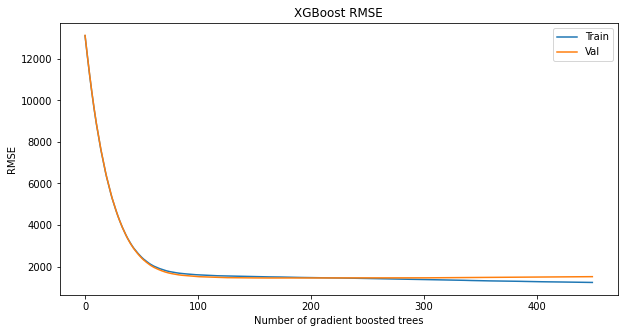

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

results = model.evals_result()
epochs = len(results['validation_0']['rmse'])

x_axis = range(0, epochs);
fig, ax = plt.subplots(1, 1, figsize=(10,5));
ax.plot(x_axis, results['validation_0']['rmse'], label='Train');
ax.plot(x_axis, results['validation_1']['rmse'], label='Val');
ax.legend();
ax.set_title('XGBoost RMSE');
ax.set_ylabel('RMSE');
ax.set_xlabel('Number of gradient boosted trees');
plt.show();
plt.tight_layout();

RMSE test: 4980.681359248389


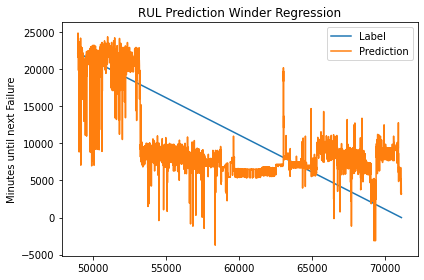

In [20]:
y_last = last_cycle["RUL"]
X_last = last_cycle.drop("RUL",axis=1)

prediction = model.predict(X_last)
prediction = prediction.flatten()
#prediction = [0 if x[0] > 0.5 else 1 for x in prediction]
print("RMSE test: {}".format(np.sqrt(mean_squared_error(y_last, prediction))))

df = pd.DataFrame({'Label': y_last, 'Prediction': prediction})

plt.plot(df['Label'], label='Label')
plt.plot(df['Prediction'], label='Prediction')
plt.ylabel("Minutes until next Failure")
plt.title("RUL Prediction Winder Regression")

plt.tight_layout()
plt.legend()
plt.savefig("rul_prediction_regr.png")
plt.show()
#for label, pred in zip(y_last, prediction):
    #print("Label: {}, Prediction: {}".format(label, pred))